<a href="https://colab.research.google.com/github/caltunay/dd_competition_heart_disease/blob/master/Heart_Disease_Prediction_stacking_models_(.35%20logloss).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, precision_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
test_values_path = '/content/drive/My Drive/Colab Notebooks/Data/Competition - DrivenData - Heart Disease Prediction/test_values (1).csv'
train_labels_path = '/content/drive/My Drive/Colab Notebooks/Data/Competition - DrivenData - Heart Disease Prediction/train_labels (1).csv'
train_values_path = '/content/drive/My Drive/Colab Notebooks/Data/Competition - DrivenData - Heart Disease Prediction/train_values (1).csv'

train_val = pd.read_csv(train_values_path)
train_lab = pd.read_csv(train_labels_path)

test_val = pd.read_csv(test_values_path)

In [0]:
def slope_type(df):
    
    """Convert slope_of_peak_exercise_st_segment
    column to string/categorical values"""
    
    if df['slope_of_peak_exercise_st_segment'] == 1:
        return 'Upslope'
    
    elif df['slope_of_peak_exercise_st_segment'] == 2:
        return 'Flat'
    
    else: 
        return 'Downslope'

In [0]:
train_val['slope_type'] = train_val.apply(slope_type, axis = 1)
test_val['slope_type'] = test_val.apply(slope_type, axis = 1)




In [0]:
def chest_pain_type(df):
    
    """Convert chest pain
    type to string/categorical values"""
    
   
    if df['chest_pain_type'] == 1:
        return 'typical angina'

    elif df['chest_pain_type'] == 2:
        return 'atypical angina'
    
    elif df['chest_pain_type'] == 3:
        return 'non-anginal angina'
    
    else:
        return 'asymptomatic'

In [0]:
train_val['chest_pain'] = train_val.apply(chest_pain_type, axis = 1)


In [0]:
test_val['chest_pain'] = test_val.apply(chest_pain_type, axis = 1)

In [0]:
def vessel_type(df):

    """Convert major vessels to categorical"""
    
    if df['num_major_vessels'] == 0:
        return 'Color 0'
    elif df['num_major_vessels'] == 1:
        return 'Color 1'
    elif df['num_major_vessels'] == 2:
        return 'Color 2'
    else:
        return 'Color 3'

In [0]:
train_val['vessel_type'] = train_val.apply(vessel_type, axis = 1)
train_val['blood_sugar'] = train_val['fasting_blood_sugar_gt_120_mg_per_dl'].map({1:"Over 120mg", 0:"Under 120mg"})
train_val['ekg'] = train_val['resting_ekg_results'].map({0:'normal', 1: 'abnormality', 2: 'hypertrophy'})
train_val['chest_pain_with_exercise'] = train_val['exercise_induced_angina'].map({0:'None', 1:'Exist'}) 
test_val['vessel_type'] = test_val.apply(vessel_type, axis = 1)



In [0]:
test_val['blood_sugar'] = test_val['fasting_blood_sugar_gt_120_mg_per_dl'].map({1:"Over 120mg", 0:"Under 120mg"})
test_val['ekg'] = test_val['resting_ekg_results'].map({0:'normal', 1: 'abnormality', 2: 'hypertrophy'})
test_val['chest_pain_with_exercise'] = test_val['exercise_induced_angina'].map({0:'None', 1:'Exist'}) 


In [0]:
drop_cols = 'slope_of_peak_exercise_st_segment chest_pain_type num_major_vessels fasting_blood_sugar_gt_120_mg_per_dl resting_ekg_results exercise_induced_angina'.split()

train_clean = train_val.drop(labels = drop_cols, axis = 1)
test_clean = test_val.drop(labels = drop_cols, axis = 1)


In [0]:
train_clean['sex'] = train_val['sex'].map({0: 'female', 1: 'male'})
test_clean['sex'] = test_val['sex'].map({0: 'female', 1: 'male'})


In [0]:
obj_cols = ['thal', 'sex', 'slope_type', 'chest_pain', 'vessel_type', 'blood_sugar', 'ekg', 'chest_pain_with_exercise']

train_dummied = pd.get_dummies(data = train_clean, prefix_sep = '|', drop_first = True, columns = obj_cols)
test_dummied = pd.get_dummies(data = test_clean, prefix_sep = '|', drop_first = True, columns = obj_cols)

In [0]:
train_dummied.head()

,patient_id,resting_blood_pressure,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,age,max_heart_rate_achieved,thal|normal,thal|reversible_defect,sex|male,slope_type|Flat,slope_type|Upslope,chest_pain|atypical angina,chest_pain|non-anginal angina,chest_pain|typical angina,vessel_type|Color 1,vessel_type|Color 2,vessel_type|Color 3,blood_sugar|Under 120mg,ekg|hypertrophy,ekg|normal,chest_pain_with_exercise|None
0,0z64un,128,308,0.0,45,170,1,0,1,0,1,1,0,0,0,0,0,1,1,0,1
1,ryoo3j,110,214,1.6,54,158,1,0,0,1,0,0,1,0,0,0,0,1,0,1,1
2,yt1s1x,125,304,0.0,77,162,1,0,1,0,1,0,0,0,0,0,1,1,1,0,0
3,l2xjde,152,223,0.0,40,181,0,1,1,0,1,0,0,0,0,0,0,1,0,1,1
4,oyt4ek,178,270,4.2,59,145,0,1,1,0,0,0,0,1,0,0,0,1,1,0,1


In [0]:
test_dummied.head()

,patient_id,resting_blood_pressure,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,age,max_heart_rate_achieved,thal|normal,thal|reversible_defect,sex|male,slope_type|Flat,slope_type|Upslope,chest_pain|atypical angina,chest_pain|non-anginal angina,chest_pain|typical angina,vessel_type|Color 1,vessel_type|Color 2,vessel_type|Color 3,blood_sugar|Under 120mg,ekg|hypertrophy,ekg|normal,chest_pain_with_exercise|None
0,olalu7,170,288,0.2,59,159,0,1,1,1,0,0,0,1,0,0,0,1,1,0,1
1,z9n6mx,138,183,1.4,35,182,1,0,0,0,1,0,0,0,0,0,0,1,0,1,1
2,5k4413,120,177,2.5,43,120,0,1,1,1,0,0,0,0,0,0,0,1,1,0,0
3,mrg7q5,102,318,0.0,60,160,1,0,0,0,1,0,1,0,1,0,0,1,0,1,1
4,uki4do,138,166,3.6,61,125,1,0,1,1,0,0,0,0,1,0,0,1,1,0,0


In [0]:
ser, eq_depression_bin = pd.qcut(x = train_dummied['oldpeak_eq_st_depression'], q = 3, labels = ['low', 'mid', 'high'], retbins = True)


In [0]:
train_dummied = pd.merge(left = train_dummied, right = ser, left_index = True, right_index = True)

In [0]:
train_dummied.drop(labels = 'oldpeak_eq_st_depression_x', axis = 1, inplace = True)

In [0]:
train_dummied.head()

,patient_id,resting_blood_pressure,serum_cholesterol_mg_per_dl,age,max_heart_rate_achieved,thal|normal,thal|reversible_defect,sex|male,slope_type|Flat,slope_type|Upslope,chest_pain|atypical angina,chest_pain|non-anginal angina,chest_pain|typical angina,vessel_type|Color 1,vessel_type|Color 2,vessel_type|Color 3,blood_sugar|Under 120mg,ekg|hypertrophy,ekg|normal,chest_pain_with_exercise|None,oldpeak_eq_st_depression_y
0,0z64un,128,308,45,170,1,0,1,0,1,1,0,0,0,0,0,1,1,0,1,low
1,ryoo3j,110,214,54,158,1,0,0,1,0,0,1,0,0,0,0,1,0,1,1,high
2,yt1s1x,125,304,77,162,1,0,1,0,1,0,0,0,0,0,1,1,1,0,0,low
3,l2xjde,152,223,40,181,0,1,1,0,1,0,0,0,0,0,0,1,0,1,1,low
4,oyt4ek,178,270,59,145,0,1,1,0,0,0,0,1,0,0,0,1,1,0,1,high


In [0]:
serum_ser, serum_bin = pd.qcut(x = train_dummied['serum_cholesterol_mg_per_dl'], q = 4, labels = ['low', 'mid-low', 'mid-high', 'high'], retbins = True)

# train_clean = pd.merge(left = train_clean, right = serum_ser, left_index = True, right_index = True)
# train_clean.drop(labels = 'serum_cholesterol_mg_per_dl_x', axis = 1, inplace = True)
# train_clean.head()

In [0]:
train_dummied = pd.merge(left = train_dummied, right = serum_ser, left_index = True, right_index = True)
train_dummied.head()

,patient_id,resting_blood_pressure,serum_cholesterol_mg_per_dl_x,age,max_heart_rate_achieved,thal|normal,thal|reversible_defect,sex|male,slope_type|Flat,slope_type|Upslope,chest_pain|atypical angina,chest_pain|non-anginal angina,chest_pain|typical angina,vessel_type|Color 1,vessel_type|Color 2,vessel_type|Color 3,blood_sugar|Under 120mg,ekg|hypertrophy,ekg|normal,chest_pain_with_exercise|None,oldpeak_eq_st_depression_y,serum_cholesterol_mg_per_dl_y
0,0z64un,128,308,45,170,1,0,1,0,1,1,0,0,0,0,0,1,1,0,1,low,high
1,ryoo3j,110,214,54,158,1,0,0,1,0,0,1,0,0,0,0,1,0,1,1,high,mid-low
2,yt1s1x,125,304,77,162,1,0,1,0,1,0,0,0,0,0,1,1,1,0,0,low,high
3,l2xjde,152,223,40,181,0,1,1,0,1,0,0,0,0,0,0,1,0,1,1,low,mid-low
4,oyt4ek,178,270,59,145,0,1,1,0,0,0,0,1,0,0,0,1,1,0,1,high,mid-high


In [0]:
train_dummied.drop(labels = 'serum_cholesterol_mg_per_dl_x', axis = 1, inplace = True)
train_dummied.head()

,patient_id,resting_blood_pressure,age,max_heart_rate_achieved,thal|normal,thal|reversible_defect,sex|male,slope_type|Flat,slope_type|Upslope,chest_pain|atypical angina,chest_pain|non-anginal angina,chest_pain|typical angina,vessel_type|Color 1,vessel_type|Color 2,vessel_type|Color 3,blood_sugar|Under 120mg,ekg|hypertrophy,ekg|normal,chest_pain_with_exercise|None,oldpeak_eq_st_depression_y,serum_cholesterol_mg_per_dl_y
0,0z64un,128,45,170,1,0,1,0,1,1,0,0,0,0,0,1,1,0,1,low,high
1,ryoo3j,110,54,158,1,0,0,1,0,0,1,0,0,0,0,1,0,1,1,high,mid-low
2,yt1s1x,125,77,162,1,0,1,0,1,0,0,0,0,0,1,1,1,0,0,low,high
3,l2xjde,152,40,181,0,1,1,0,1,0,0,0,0,0,0,1,0,1,1,low,mid-low
4,oyt4ek,178,59,145,0,1,1,0,0,0,0,1,0,0,0,1,1,0,1,high,mid-high


In [0]:
test_dummied.head()

test_dep = pd.cut(test_dummied['oldpeak_eq_st_depression'], bins = eq_depression_bin, labels = ['low', 'mid', 'high'], include_lowest = True)

test_dummied = pd.merge(left = test_dummied, right = test_dep, left_index = True, right_index = True)
test_dummied.drop(labels = 'oldpeak_eq_st_depression_x', axis = 1, inplace = True)


In [0]:
test_temp2 = pd.cut(test_dummied['serum_cholesterol_mg_per_dl'], bins = serum_bin, labels = ['low', 'mid-low', 'mid-high', 'high'], include_lowest = True )

test_dummied = pd.merge(left = test_dummied, right = test_temp2, left_index = True, right_index = True)
test_dummied.drop(labels = 'serum_cholesterol_mg_per_dl_x', axis = 1, inplace = True)

test_dummied.head()

,patient_id,resting_blood_pressure,age,max_heart_rate_achieved,thal|normal,thal|reversible_defect,sex|male,slope_type|Flat,slope_type|Upslope,chest_pain|atypical angina,chest_pain|non-anginal angina,chest_pain|typical angina,vessel_type|Color 1,vessel_type|Color 2,vessel_type|Color 3,blood_sugar|Under 120mg,ekg|hypertrophy,ekg|normal,chest_pain_with_exercise|None,oldpeak_eq_st_depression_y,serum_cholesterol_mg_per_dl_y
0,olalu7,170,59,159,0,1,1,1,0,0,0,1,0,0,0,1,1,0,1,mid,high
1,z9n6mx,138,35,182,1,0,0,0,1,0,0,0,0,0,0,1,0,1,1,mid,low
2,5k4413,120,43,120,0,1,1,1,0,0,0,0,0,0,0,1,1,0,0,high,low
3,mrg7q5,102,60,160,1,0,0,0,1,0,1,0,1,0,0,1,0,1,1,low,high
4,uki4do,138,61,125,1,0,1,1,0,0,0,0,1,0,0,1,1,0,0,high,low


In [0]:
train_dummied = pd.get_dummies(data = train_dummied, columns = ['oldpeak_eq_st_depression_y', 'serum_cholesterol_mg_per_dl_y'], drop_first = True, prefix_sep= '|')
test_dummied = pd.get_dummies(data = test_dummied, columns = ['oldpeak_eq_st_depression_y', 'serum_cholesterol_mg_per_dl_y'], drop_first = True, prefix_sep= '|')

In [0]:
train_dummied.shape

(180, 24)

In [0]:
test_dummied.shape

(90, 24)

In [0]:
train_dummied.head()

,patient_id,resting_blood_pressure,age,max_heart_rate_achieved,thal|normal,thal|reversible_defect,sex|male,slope_type|Flat,slope_type|Upslope,chest_pain|atypical angina,chest_pain|non-anginal angina,chest_pain|typical angina,vessel_type|Color 1,vessel_type|Color 2,vessel_type|Color 3,blood_sugar|Under 120mg,ekg|hypertrophy,ekg|normal,chest_pain_with_exercise|None,oldpeak_eq_st_depression_y|mid,oldpeak_eq_st_depression_y|high,serum_cholesterol_mg_per_dl_y|mid-low,serum_cholesterol_mg_per_dl_y|mid-high,serum_cholesterol_mg_per_dl_y|high
0,0z64un,128,45,170,1,0,1,0,1,1,0,0,0,0,0,1,1,0,1,0,0,0,0,1
1,ryoo3j,110,54,158,1,0,0,1,0,0,1,0,0,0,0,1,0,1,1,0,1,1,0,0
2,yt1s1x,125,77,162,1,0,1,0,1,0,0,0,0,0,1,1,1,0,0,0,0,0,0,1
3,l2xjde,152,40,181,0,1,1,0,1,0,0,0,0,0,0,1,0,1,1,0,0,1,0,0
4,oyt4ek,178,59,145,0,1,1,0,0,0,0,1,0,0,0,1,1,0,1,0,1,0,1,0


In [0]:
test_dummied.head()

,patient_id,resting_blood_pressure,age,max_heart_rate_achieved,thal|normal,thal|reversible_defect,sex|male,slope_type|Flat,slope_type|Upslope,chest_pain|atypical angina,chest_pain|non-anginal angina,chest_pain|typical angina,vessel_type|Color 1,vessel_type|Color 2,vessel_type|Color 3,blood_sugar|Under 120mg,ekg|hypertrophy,ekg|normal,chest_pain_with_exercise|None,oldpeak_eq_st_depression_y|mid,oldpeak_eq_st_depression_y|high,serum_cholesterol_mg_per_dl_y|mid-low,serum_cholesterol_mg_per_dl_y|mid-high,serum_cholesterol_mg_per_dl_y|high
0,olalu7,170,59,159,0,1,1,1,0,0,0,1,0,0,0,1,1,0,1,1,0,0,0,1
1,z9n6mx,138,35,182,1,0,0,0,1,0,0,0,0,0,0,1,0,1,1,1,0,0,0,0
2,5k4413,120,43,120,0,1,1,1,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0
3,mrg7q5,102,60,160,1,0,0,0,1,0,1,0,1,0,0,1,0,1,1,0,0,0,0,1
4,uki4do,138,61,125,1,0,1,1,0,0,0,0,1,0,0,1,1,0,0,0,1,0,0,0


In [0]:
ssx = StandardScaler()

In [0]:
# seperate to_scale and rest, 
# scale to_scale, and merge to rest
to_scale = 'resting_blood_pressure age max_heart_rate_achieved'.split()

rest_df = train_dummied.drop(labels = to_scale, axis = 1)
to_scale_np = train_dummied[to_scale].values

scaled_x_np = ssx.fit_transform(to_scale_np)
scaled_df = pd.DataFrame(scaled_x_np, columns = to_scale)
train_clean = pd.concat([rest_df, scaled_df], axis = 1)

rest_test_df = test_dummied.drop(labels = to_scale, axis = 1)
to_scale_test_np = test_dummied[to_scale].values

scaled_test_x_np = ssx.transform(to_scale_test_np)
scaled_test_df = pd.DataFrame(scaled_test_x_np, columns = to_scale)
test_clean = pd.concat([rest_test_df, scaled_test_df], axis = 1)

In [0]:
train_clean.head()

,patient_id,thal|normal,thal|reversible_defect,sex|male,slope_type|Flat,slope_type|Upslope,chest_pain|atypical angina,chest_pain|non-anginal angina,chest_pain|typical angina,vessel_type|Color 1,vessel_type|Color 2,vessel_type|Color 3,blood_sugar|Under 120mg,ekg|hypertrophy,ekg|normal,chest_pain_with_exercise|None,oldpeak_eq_st_depression_y|mid,oldpeak_eq_st_depression_y|high,serum_cholesterol_mg_per_dl_y|mid-low,serum_cholesterol_mg_per_dl_y|mid-high,serum_cholesterol_mg_per_dl_y|high,resting_blood_pressure,age,max_heart_rate_achieved
0,0z64un,1,0,1,0,1,1,0,0,0,0,0,1,1,0,1,0,0,0,0,1,-0.195195,-1.053964,0.932485
1,ryoo3j,1,0,0,1,0,0,1,0,0,0,0,1,0,1,1,0,1,1,0,0,-1.256320,-0.087134,0.387084
2,yt1s1x,1,0,1,0,1,0,0,0,0,0,1,1,1,0,0,0,0,0,0,1,-0.372049,2.383654,0.568884
3,l2xjde,0,1,1,0,1,0,0,0,0,0,0,1,0,1,1,0,0,1,0,0,1.219639,-1.591092,1.432436
4,oyt4ek,0,1,1,0,0,0,0,1,0,0,0,1,1,0,1,0,1,0,1,0,2.752375,0.449994,-0.203768


In [0]:
train_lab.head()

,patient_id,heart_disease_present
0,0z64un,0
1,ryoo3j,0
2,yt1s1x,1
3,l2xjde,1
4,oyt4ek,0


In [0]:
x = train_clean.drop(labels = 'patient_id', axis = 1).values
y = train_lab['heart_disease_present'].values

In [0]:
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression

In [0]:
params = {
    'svc__gamma':[0.10]
}

vote_clf = VotingClassifier(estimators=[
    ('lr', LogisticRegression())
    ('rf', RandomForestClassifier(n_estimators = 8)),
    ('svc', SVC(C = 10, kernel = 'linear', probability = True, gamma = 0.1)),
    ('xg', XGBClassifier(objective='binary:logistic', n_estimators = 11))], voting='soft',)


gs_rf = GridSearchCV(estimator = vote_clf, param_grid = params, cv = 10, n_jobs = -1, verbose = 2)
gs_rf_result = gs_rf.fit(x, y)


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.5s finished


In [0]:
gs_rf.best_params_

{'svc__gamma': 0.1}

In [0]:
x_test = test_clean.drop(labels = 'patient_id', axis = 1).values

pred = pd.DataFrame(gs_rf_result.predict_proba(x_test))

pred.rename({1:'heart_disease_present'}, axis = 1, inplace = True)
pred.drop(labels = 0, axis = 1, inplace = True)

pred_df = pd.concat([test_clean[['patient_id']], pred], axis = 1)

pred_df.set_index('patient_id', inplace = True)

NameError: ignored

In [0]:
pred_df

In [0]:
pred_df.to_csv('StackedClassifier.csv')

In [0]:
import seaborn as sns

In [0]:
plain_df = train_clean.drop(labels = 'patient_id', axis = 1)

plain_df = pd.concat([plain_df, train_lab['heart_disease_present']], axis = 1)

plain_df.head()

,thal|normal,thal|reversible_defect,sex|male,slope_type|Flat,slope_type|Upslope,chest_pain|atypical angina,chest_pain|non-anginal angina,chest_pain|typical angina,vessel_type|Color 1,vessel_type|Color 2,vessel_type|Color 3,blood_sugar|Under 120mg,ekg|hypertrophy,ekg|normal,chest_pain_with_exercise|None,oldpeak_eq_st_depression_y|mid,oldpeak_eq_st_depression_y|high,serum_cholesterol_mg_per_dl_y|mid-low,serum_cholesterol_mg_per_dl_y|mid-high,serum_cholesterol_mg_per_dl_y|high,resting_blood_pressure,age,max_heart_rate_achieved,heart_disease_present
0,1,0,1,0,1,1,0,0,0,0,0,1,1,0,1,0,0,0,0,1,-0.195195,-1.053964,0.932485,0
1,1,0,0,1,0,0,1,0,0,0,0,1,0,1,1,0,1,1,0,0,-1.256320,-0.087134,0.387084,0
2,1,0,1,0,1,0,0,0,0,0,1,1,1,0,0,0,0,0,0,1,-0.372049,2.383654,0.568884,1
3,0,1,1,0,1,0,0,0,0,0,0,1,0,1,1,0,0,1,0,0,1.219639,-1.591092,1.432436,1
4,0,1,1,0,0,0,0,1,0,0,0,1,1,0,1,0,1,0,1,0,2.752375,0.449994,-0.203768,0


/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


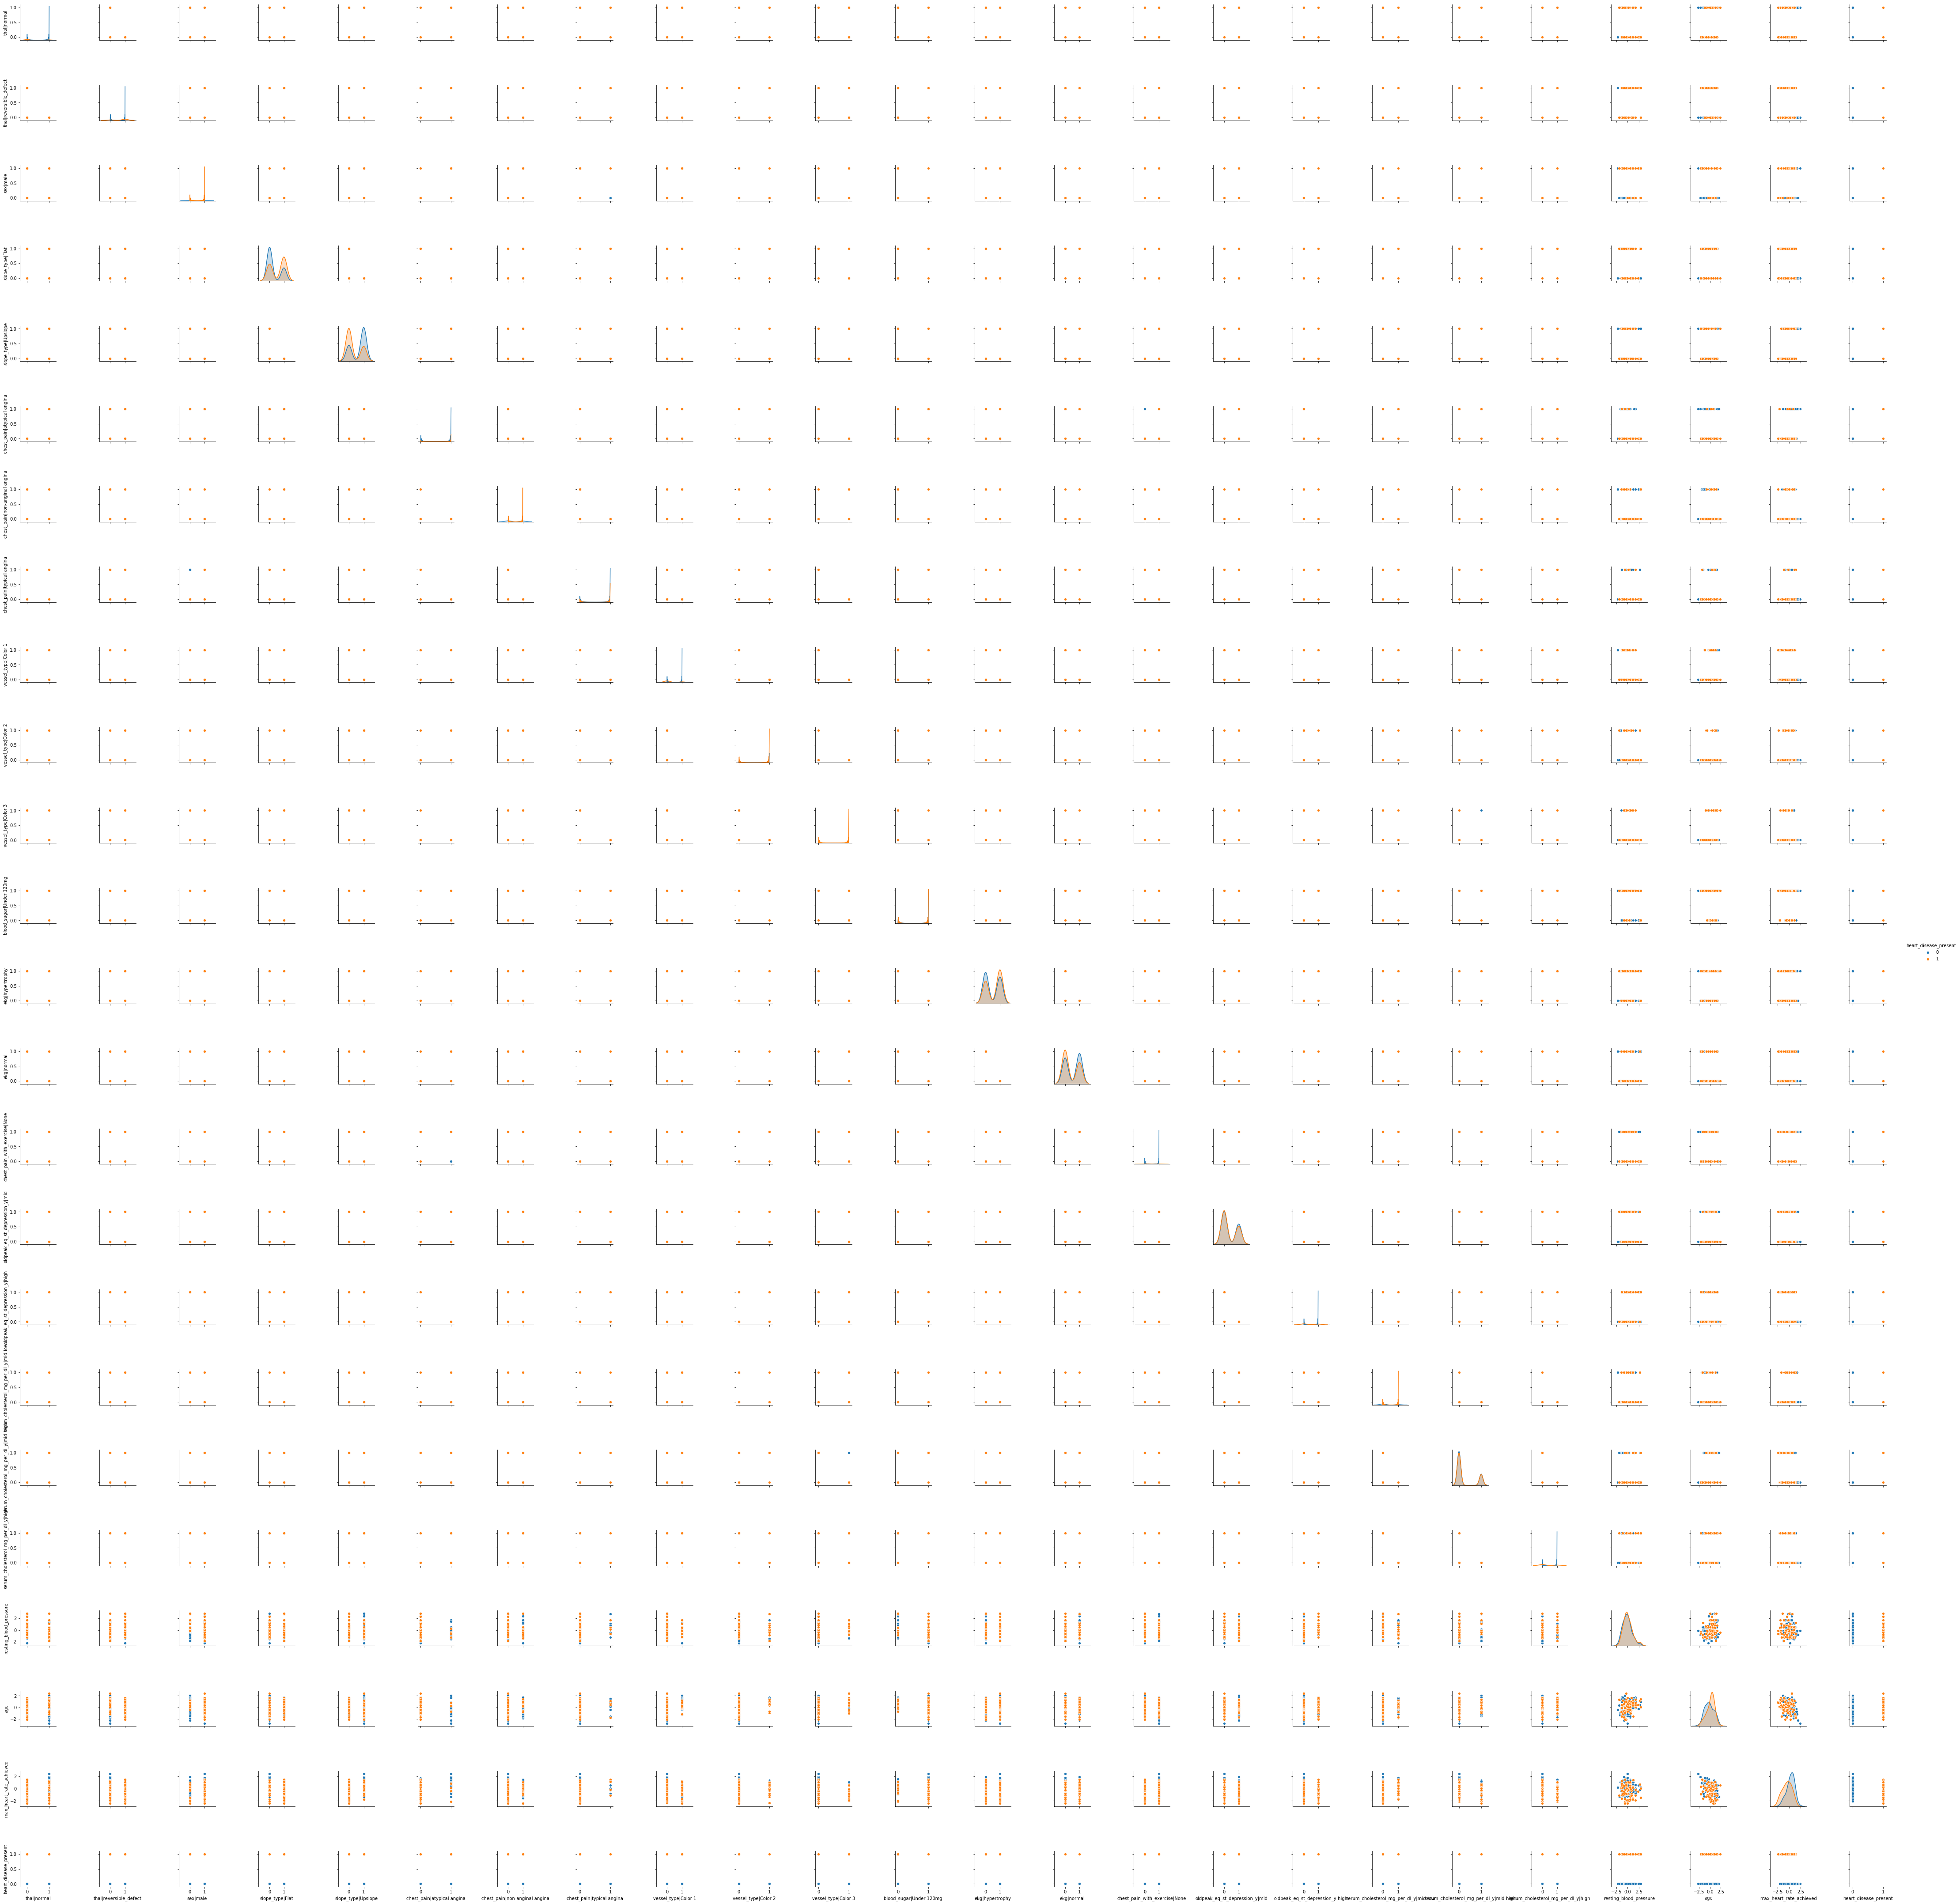

In [0]:
sns.pairplot(plain_df, hue = 'heart_disease_present
             ')

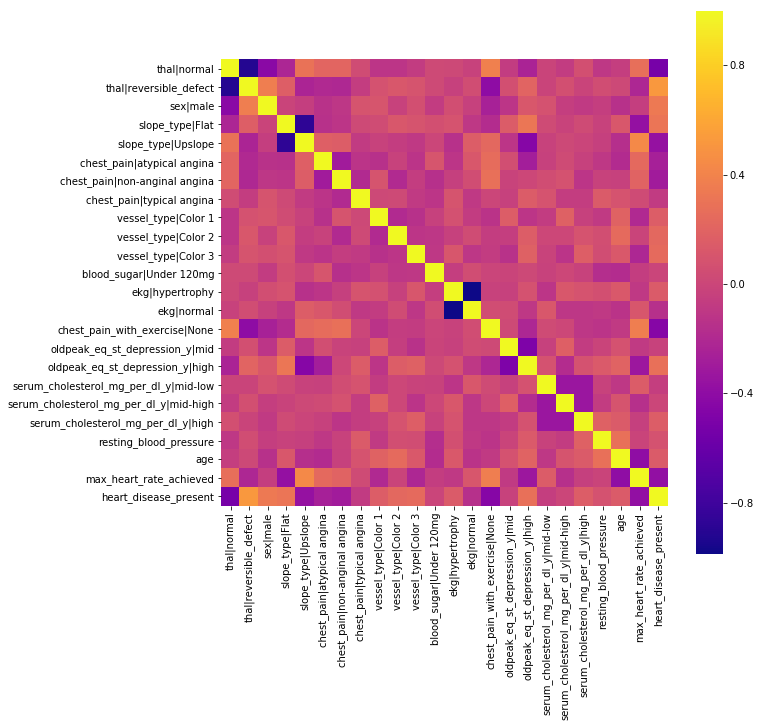

In [0]:
plt.figure(figsize = (10,10))
sns.heatmap(plain_df.corr(), cmap = 'plasma',square = True);

In [0]:
pd.DataFrame(plain_df.corr().unstack().drop_duplicates()).sort_values(by = 0, ascending = True)

,,0
ekg|hypertrophy,ekg|normal,-0.988923
thal|normal,thal|reversible_defect,-0.913417
slope_type|Flat,slope_type|Upslope,-0.873812
thal|normal,heart_disease_present,-0.528812
oldpeak_eq_st_depression_y|mid,oldpeak_eq_st_depression_y|high,-0.491536
chest_pain_with_exercise|None,heart_disease_present,-0.448647
slope_type|Upslope,oldpeak_eq_st_depression_y|high,-0.448390
thal|normal,sex|male,-0.421950
thal|reversible_defect,chest_pain_with_exercise|None,-0.402114
age,max_heart_rate_achieved,-0.394630


In [0]:
plain_df['thal|normal'].sum()#, 'thal|reversible_defect']

98

In [0]:
to_drop = 'ekg|hypertrophy thal|normal slope_type|Flat'.split()
to_drop

['ekg|hypertrophy', 'thal|normal', 'slope_type|Flat']

In [0]:
# seperate to_scale and rest, 
# scale to_scale, and merge to rest


to_scale = 'resting_blood_pressure age max_heart_rate_achieved'.split()

rest_df = train_dummied.drop(labels = to_scale, axis = 1)
to_scale_np = train_dummied[to_scale].values

scaled_x_np = ssx.fit_transform(to_scale_np)
scaled_df = pd.DataFrame(scaled_x_np, columns = to_scale)
train_clean = pd.concat([rest_df, scaled_df], axis = 1)

rest_test_df = test_dummied.drop(labels = to_scale, axis = 1)
to_scale_test_np = test_dummied[to_scale].values

scaled_test_x_np = ssx.transform(to_scale_test_np)
scaled_test_df = pd.DataFrame(scaled_test_x_np, columns = to_scale)
test_clean = pd.concat([rest_test_df, scaled_test_df], axis = 1)

to_drop = 'ekg|hypertrophy thal|normal slope_type|Flat'.split()
train_clean = train_clean.drop(labels = to_drop, axis = 1)
test_clean = test_clean.drop(labels = to_drop, axis = 1)

In [0]:
x2 = train_clean.drop(labels = 'patient_id', axis = 1).values
y2 = train_lab['heart_disease_present'].values

In [0]:
params2 = {
    'svc__gamma':[0.5,0.1, 0.05],
    'rf__n_estimators':np.arange(5,15),
    'svc__C': [0.05,.1,1,10],
    'svc__gamma':[0.05,.1,1],
    'xg__n_estimators':np.arange(8,16),
    'lr__penalty': ['l1', 'l2'],
    'lr__C': np.logspace(0, 4, 10)
}

vote_clf2 = VotingClassifier(estimators=[
    ('lr', LogisticRegression()),
    ('rf', RandomForestClassifier()),
    ('svc', SVC(kernel = 'linear', probability = True)),
    ('xg', XGBClassifier(objective='binary:logistic'))], voting='soft',)


gs_rf2 = GridSearchCV(estimator = vote_clf2, param_grid = params2, cv = 10, n_jobs = -1, verbose = 2)
gs_rf_result2 = gs_rf2.fit(x2, y2)


Fitting 10 folds for each of 19200 candidates, totalling 192000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 116 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 842 tasks      | elapsed:   20.5s
[Parallel(n_jobs=-1)]: Done 2060 tasks      | elapsed:   52.9s
[Parallel(n_jobs=-1)]: Done 3758 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 5948 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 8618 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 11780 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 15422 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 19556 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 24170 tasks      | elapsed: 11.1min
[Parallel(n_jobs=-1)]: Done 29276 tasks      | elapsed: 13.5min
[Parallel(n_jobs=-1)]: Done 34862 tasks      | elapsed: 16.0min
[Parallel(n_jobs=-1)]: Done 40940 tasks      | elapsed: 18.9min
[Parallel(n_jobs=-1)]: Done 47498 tasks      | elapsed: 22.0min
[Parallel(n_jobs=-1)]: Done 54548 ta

In [0]:
gs_rf_result2.best_params_

{'lr__C': 1291.5496650148827,
 'lr__penalty': 'l2',
 'rf__n_estimators': 5,
 'svc__C': 10,
 'svc__gamma': 0.05,
 'xg__n_estimators': 10}

In [0]:
xtest2 = test_clean.drop(labels = 'patient_id', axis = 1).values

prob_df = pd.DataFrame(gs_rf_result2.predict_proba(xtest2), columns = ['none','heart_disease_present'])

pred_df2 = pd.concat([test_clean[['patient_id']],prob_df], axis = 1)

pred_df2.drop(labels = 'none', axis = 1, inplace = True)
pred_df2.set_index('patient_id', inplace = True)
pred_df2.head()

,heart_disease_present
patient_id,
olalu7,0.590605
z9n6mx,0.097931
5k4413,0.873726
mrg7q5,0.143184
uki4do,0.802501


In [0]:
pred_df2.to_csv('Vote_Preds.csv')

In [0]:

params3 = {
    'rf__n_estimators':[4],
    'svc__C': [10],
    'svc__gamma':[0.035],
    'xg__n_estimators':[10],
    'lr__penalty': ['l2'],
    'lr__C': [1291.5496650148827]
}

vote_clf3 = VotingClassifier(estimators=[
    ('lr', LogisticRegression()),
    ('rf', RandomForestClassifier()),
    ('svc', SVC(kernel = 'linear', probability = True)),
    ('xg', XGBClassifier(objective='binary:logistic'))], voting='soft',)


gs_rf3 = GridSearchCV(estimator = vote_clf3, param_grid = params3, cv = 10, n_jobs = -1, verbose = 2)
gs_rf_result3 = gs_rf3.fit(x2, y2)


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.4s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [0]:
xtest3 = test_clean.drop(labels = 'patient_id', axis = 1).values

prob_df2 = pd.DataFrame(gs_rf_result3.predict_proba(xtest3), columns = ['none','heart_disease_present'])

pred_df3 = pd.concat([test_clean[['patient_id']],prob_df2], axis = 1)

pred_df3.drop(labels = 'none', axis = 1, inplace = True)
pred_df3.set_index('patient_id', inplace = True)
pred_df3.head()

,heart_disease_present
patient_id,
olalu7,0.616446
z9n6mx,0.085545
5k4413,0.885294
mrg7q5,0.192374
uki4do,0.812014


In [0]:
pred_df3.to_csv('Vote_preds.csv')

In [0]:
check_bias = pd.DataFrame(train_clean.nunique()).sort_values(by = 0).index.values.tolist()[:17]

for i in check_bias:
    print(train_clean[i].value_counts(normalize = True))

1    0.838889
0    0.161111
Name: blood_sugar|Under 120mg, dtype: float64
0    0.75
1    0.25
Name: serum_cholesterol_mg_per_dl_y|mid-high, dtype: float64
0    0.75
1    0.25
Name: serum_cholesterol_mg_per_dl_y|mid-low, dtype: float64
0    0.705556
1    0.294444
Name: oldpeak_eq_st_depression_y|high, dtype: float64
0    0.633333
1    0.366667
Name: oldpeak_eq_st_depression_y|mid, dtype: float64
1    0.683333
0    0.316667
Name: chest_pain_with_exercise|None, dtype: float64
0    0.527778
1    0.472222
Name: ekg|normal, dtype: float64
0    0.75
1    0.25
Name: serum_cholesterol_mg_per_dl_y|high, dtype: float64
0    0.922222
1    0.077778
Name: vessel_type|Color 3, dtype: float64
0    0.794444
1    0.205556
Name: vessel_type|Color 1, dtype: float64
0    0.927778
1    0.072222
Name: chest_pain|typical angina, dtype: float64
0    0.683333
1    0.316667
Name: chest_pain|non-anginal angina, dtype: float64
0    0.844444
1    0.155556
Name: chest_pain|atypical angina, dtype: float64
1    0.5166

In [0]:
test_clean.head()

,patient_id,thal|reversible_defect,sex|male,slope_type|Upslope,chest_pain|atypical angina,chest_pain|non-anginal angina,chest_pain|typical angina,vessel_type|Color 1,vessel_type|Color 2,vessel_type|Color 3,blood_sugar|Under 120mg,ekg|normal,chest_pain_with_exercise|None,oldpeak_eq_st_depression_y|mid,oldpeak_eq_st_depression_y|high,serum_cholesterol_mg_per_dl_y|mid-low,serum_cholesterol_mg_per_dl_y|mid-high,serum_cholesterol_mg_per_dl_y|high,resting_blood_pressure,age,max_heart_rate_achieved
0,olalu7,1,1,0,0,0,1,0,0,0,1,0,1,1,0,0,0,1,2.280764,0.449994,0.432534
1,z9n6mx,0,0,1,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0.394319,-2.128220,1.477887
2,5k4413,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,-0.666806,-1.268815,-1.340021
3,mrg7q5,0,0,1,0,1,0,1,0,0,1,1,1,0,0,0,0,1,-1.727931,0.557419,0.477984
4,uki4do,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0.394319,0.664845,-1.112771


In [0]:
all = pd.concat([train_clean, train_lab], axis = 1)

disease1 = all[all['heart_disease_present'] == 1]
disease0 = all[all['heart_disease_present'] == 0]

disease1.shape

(80, 23)

In [0]:
disease0 = disease0.sample(n = len(disease1),random_state = 42)

In [0]:
undersampled = pd.concat([disease0, disease1], axis = 0)
undersampled.shape

(160, 23)

array([1.00000000e+00, 3.59381366e+00, 1.29154967e+01, 4.64158883e+01,
       1.66810054e+02, 5.99484250e+02, 2.15443469e+03, 7.74263683e+03,
       2.78255940e+04, 1.00000000e+05])

In [1]:
x_us = undersampled.drop(labels = ['patient_id', 'heart_disease_present'], axis = 1).values
y_us = undersampled['heart_disease_present'].values


params4 = {
    'rf__n_estimators':np.arange(2,10),
    'svc__C': [0.01, 0.1, 1],
    'svc__gamma':[0.01, 0.1, 1],
    'lr__C': [0.65, 0.25, 0.5]
}

vote_clf4 = VotingClassifier(estimators=[
    ('lr', LogisticRegression(penalty = 'l2')),
    ('rf', RandomForestClassifier()),
    ('svc', SVC(kernel = 'linear', probability = True)),
    ('xg', XGBClassifier(objective='binary:logistic'))], voting='soft',)


gs_rf4 = GridSearchCV(estimator = vote_clf4, param_grid = params4, cv = 10, n_jobs = -1, verbose = 2, scoring = 'neg_log_loss' )
gs_rf_result4 = gs_rf4.fit(x_us, y_us)



NameError: ignored

In [0]:
gs_rf_result4.best_params_

{'lr__C': 0.25, 'rf__n_estimators': 5, 'svc__C': 1, 'svc__gamma': 0.1}